# Machine Learning using PySpark

## Classification

### Binary classification

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("PySpark logistic regression Binary") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [2]:
spark

### load data

In [7]:
path = 'file:///Users/tjmask/Desktop/Semester2/Spark/PySpark/Datasets/eBayAuctions.csv'
df = spark.read.csv(path, header='true',inferSchema='true')

df.show(5)

+----------------+--------+------------+--------+------+----------+---------+------------+
|        Category|currency|sellerRating|Duration|endDay|ClosePrice|OpenPrice|Competitive?|
+----------------+--------+------------+--------+------+----------+---------+------------+
|Music/Movie/Game|      US|        3249|       5|   Mon|      0.01|     0.01|           0|
|Music/Movie/Game|      US|        3249|       5|   Mon|      0.01|     0.01|           0|
|Music/Movie/Game|      US|        3249|       5|   Mon|      0.01|     0.01|           0|
|Music/Movie/Game|      US|        3249|       5|   Mon|      0.01|     0.01|           0|
|Music/Movie/Game|      US|        3249|       5|   Mon|      0.01|     0.01|           0|
+----------------+--------+------------+--------+------+----------+---------+------------+
only showing top 5 rows



In [15]:
## renaming columns
df = df.withColumnRenamed('Competitive?','CompetitiveOrNot')

In [16]:
df.printSchema()

root
 |-- Category: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- sellerRating: integer (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- endDay: string (nullable = true)
 |-- ClosePrice: double (nullable = true)
 |-- OpenPrice: double (nullable = true)
 |-- CompetitiveOrNot: integer (nullable = true)



In [9]:
df.describe().show()

+-------+-----------------+--------+-----------------+------------------+------+-----------------+------------------+------------------+
|summary|         Category|currency|     sellerRating|          Duration|endDay|       ClosePrice|         OpenPrice|      Competitive?|
+-------+-----------------+--------+-----------------+------------------+------+-----------------+------------------+------------------+
|  count|             1972|    1972|             1972|              1972|  1972|             1972|              1972|              1972|
|   mean|             null|    null|3560.238336713996|  6.48630831643002|  null|36.44908722109523|12.926267748478686|0.5405679513184585|
| stddev|             null|    null|5973.011032512105|2.0529063093178253|  null|89.49385836475687|38.856149207927324|0.4984779288063969|
|    min|Antique/Art/Craft|     EUR|                0|                 1|   Fri|             0.01|              0.01|                 0|
|    max|     Toys/Hobbies|      US|     

### deal with category Variables

In [20]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]
    print(indexers)
    
    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]
    print(encoders)
    
    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")
    print(assembler)
    
    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

In [18]:
catCols = ['Category','currency','endDay']
numCols = ['sellerRating', 'Duration', 'ClosePrice','OpenPrice']
labelCol = 'CompetitiveOrNot'

data = get_dummy(df,catCols,numCols,labelCol)
data.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(29,[0,17,19,25,2...|    0|
|(29,[0,17,19,25,2...|    0|
|(29,[0,17,19,25,2...|    0|
|(29,[0,17,19,25,2...|    0|
|(29,[0,17,19,25,2...|    0|
+--------------------+-----+
only showing top 5 rows



In [21]:
get_dummy(df,catCols,numCols,labelCol)

[StringIndexer_702641b88d6c, StringIndexer_edb0e829e50f, StringIndexer_11cac07ee129]
[OneHotEncoder_c03e15a42fdf, OneHotEncoder_f99c3a6de417, OneHotEncoder_a9e5f420f061]
VectorAssembler_6d6e997307cd


DataFrame[features: vector, label: int]

In [22]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])

trainingData.show(5,False)
testData.show(5,False)

+-------------------------------------------------------------+-----+
|features                                                     |label|
+-------------------------------------------------------------+-----+
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,133.0,5.0,22.76,8.99])|1    |
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,841.0,5.0,0.99,0.99]) |0    |
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,841.0,5.0,0.99,0.99]) |0    |
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,841.0,5.0,0.99,0.99]) |0    |
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,841.0,5.0,0.99,0.99]) |1    |
+-------------------------------------------------------------+-----+
only showing top 5 rows

+-------------------------------------------------------------+-----+
|features                                                     |label|
+-------------------------------------------------------------+-----+
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,133.0,5.0,45.44,8.99])|1    |
|(29,[0,17,19,25,26,27,28],[1.0,1.0,1.0,471.0,5.0,9.5,0.99])  |1 

In [23]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='features', labelCol='label')

In [ ]:
# # Convert indexed labels back to original labels.
# labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
#                                labels=labelIndexer.labels)

In [25]:
# Chain indexers and tree in a Pipeline
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[logr])

In [26]:
model = pipeline.fit(trainingData)

In [27]:
# Make predictions.
predictions = model.transform(testData)
# Select example rows to display.
predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(29,[0,17,19,25,2...|    1|[-3.7287406917122...|[0.02345950005208...|       1.0|
|(29,[0,17,19,25,2...|    1|[-1.2875114696054...|[0.21627431824413...|       1.0|
|(29,[0,17,19,25,2...|    0|[-0.5051900452951...|[0.37632176632058...|       1.0|
|(29,[0,17,19,25,2...|    1|[-0.6665028477303...|[0.33928035342635...|       1.0|
|(29,[0,17,19,25,2...|    1|[-0.7764478862616...|[0.31508595235784...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [28]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.227217


In [60]:
lrModel = model.stages[0]
trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)
maxFMeasure
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|0.037037037037037035|
|0.003787878787878788| 0.04830917874396135|
|0.003787878787878788| 0.06280193236714976|
|0.003787878787878788| 0.07729468599033816|
+--------------------+--------------------+
only showing top 5 rows

areaUnderROC: 0.8563991362904404


[Row(max(F-Measure)=0.7939053728949479)]

In [33]:
roc_data = trainingSummary.roc
roc_data.count()

109

### zeppelin

In [52]:
import seaborn as sns
x = roc_data[['FPR']].toPandas()['FPR']
y = roc_data[['TPR']].toPandas()['TPR']

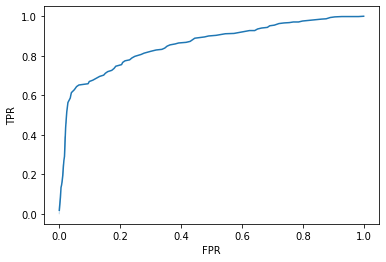

In [53]:
sns.lineplot(x=x, y=y)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [72]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()
class_temp

class_names = map(str, class_temp)
class_names

In [82]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=[1,0])
cnf_matrix

array([[343, 102],
       [ 85, 293]])

Confusion matrix, without normalization
[[343 102]
 [ 85 293]]


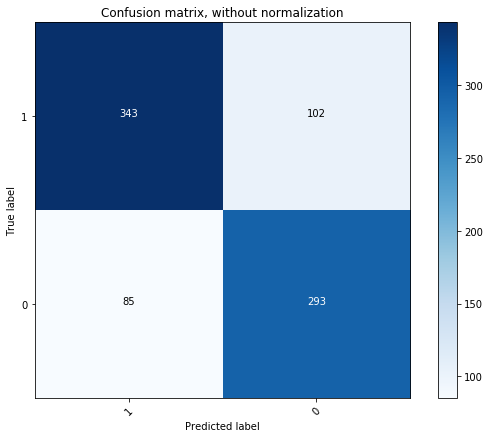

In [83]:
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['1','0'],
                      title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.77078652 0.22921348]
 [0.22486772 0.77513228]]


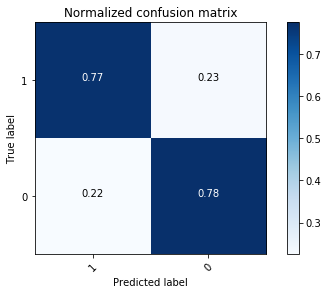

In [85]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['1','0'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()